In [7]:
import pandas as pd

# Load the dataset
data = pd.read_csv('D:/Bristol/Group Project/vdjdb-2023-06-01/vdjdb.txt', sep='\t')

# Display the first few rows of the dataframe
print(data.head())

# Inspecting the structure of the dataset
print(data.info())


   complex.id gene                  cdr3       v.segm      j.segm  \
0           1  TRA         CIVRAPGRADMRF  TRAV26-1*01   TRAJ43*01   
1           1  TRB  CASSYLPGQGDHYSNQPQHF    TRBV13*01  TRBJ1-5*01   
2           0  TRB   CASSFEAGQGFFSNQPQHF    TRBV13*01  TRBJ1-5*01   
3           2  TRA        CAVPSGAGSYQLTF    TRAV20*01   TRAJ28*01   
4           2  TRB   CASSFEPGQGFYSNQPQHF    TRBV13*01  TRBJ1-5*01   

       species     mhc.a mhc.b mhc.class antigen.epitope  ... antigen.species  \
0  HomoSapiens  HLA-B*08   B2M      MHCI        FLKEKGGL  ...           HIV-1   
1  HomoSapiens  HLA-B*08   B2M      MHCI        FLKEKGGL  ...           HIV-1   
2  HomoSapiens  HLA-B*08   B2M      MHCI        FLKEKGGL  ...           HIV-1   
3  HomoSapiens  HLA-B*08   B2M      MHCI        FLKEKGGL  ...           HIV-1   
4  HomoSapiens  HLA-B*08   B2M      MHCI        FLKEKGGL  ...           HIV-1   

    reference.id                                             method  \
0  PMID:15596521  {"frequen

In [8]:
def generate_kmers(sequence, k=3):
    kmers = [sequence[i:i+k] for i in range(len(sequence) - k + 1)]
    return kmers

# Apply this function to each sequence in the CDR3 column
data['kmers'] = data['cdr3'].apply(lambda x: generate_kmers(x, 3))

# Let's see the first few entries to verify
print(data[['cdr3', 'kmers']].head())


                   cdr3                                              kmers
0         CIVRAPGRADMRF  [CIV, IVR, VRA, RAP, APG, PGR, GRA, RAD, ADM, ...
1  CASSYLPGQGDHYSNQPQHF  [CAS, ASS, SSY, SYL, YLP, LPG, PGQ, GQG, QGD, ...
2   CASSFEAGQGFFSNQPQHF  [CAS, ASS, SSF, SFE, FEA, EAG, AGQ, GQG, QGF, ...
3        CAVPSGAGSYQLTF  [CAV, AVP, VPS, PSG, SGA, GAG, AGS, GSY, SYQ, ...
4   CASSFEPGQGFYSNQPQHF  [CAS, ASS, SSF, SFE, FEP, EPG, PGQ, GQG, QGF, ...


In [9]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a count vectorizer object
vectorizer = CountVectorizer(token_pattern='(?u)\\b\\w+\\b', ngram_range=(1,1))

# Flatten the list of k-mers to fit the vectorizer
all_kmers = [kmer for sublist in data['kmers'].tolist() for kmer in sublist]
vectorizer.fit(all_kmers)

# Transform the k-mers in each sequence into a feature vector
data['kmer_vectors'] = data['kmers'].apply(lambda x: vectorizer.transform([' '.join(x)]).toarray()[0])

# Display transformed feature vectors
print(data[['cdr3', 'kmer_vectors']].head())


                   cdr3                                       kmer_vectors
0         CIVRAPGRADMRF  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1  CASSYLPGQGDHYSNQPQHF  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2   CASSFEAGQGFFSNQPQHF  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3        CAVPSGAGSYQLTF  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4   CASSFEPGQGFYSNQPQHF  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple neural network
class AntigenPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(AntigenPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters
input_size = len(vectorizer.get_feature_names_out())

hidden_size = 50  # Adjust based on performance and complexity
num_classes = len(data['antigen.epitope'].unique())  # Number of different antigens

# Initialize the model
model = AntigenPredictor(input_size, hidden_size, num_classes).to(device)


Epoch [1/500], Loss: 6.8880
Epoch [2/500], Loss: 6.8652
Epoch [3/500], Loss: 6.8410
Epoch [4/500], Loss: 6.8153
Epoch [5/500], Loss: 6.7882
Epoch [6/500], Loss: 6.7595
Epoch [7/500], Loss: 6.7293
Epoch [8/500], Loss: 6.6975
Epoch [9/500], Loss: 6.6639
Epoch [10/500], Loss: 6.6286
Epoch [11/500], Loss: 6.5916
Epoch [12/500], Loss: 6.5527
Epoch [13/500], Loss: 6.5119
Epoch [14/500], Loss: 6.4693
Epoch [15/500], Loss: 6.4246
Epoch [16/500], Loss: 6.3780
Epoch [17/500], Loss: 6.3294
Epoch [18/500], Loss: 6.2786
Epoch [19/500], Loss: 6.2259
Epoch [20/500], Loss: 6.1710
Epoch [21/500], Loss: 6.1140
Epoch [22/500], Loss: 6.0550
Epoch [23/500], Loss: 5.9938
Epoch [24/500], Loss: 5.9307
Epoch [25/500], Loss: 5.8656
Epoch [26/500], Loss: 5.7985
Epoch [27/500], Loss: 5.7296
Epoch [28/500], Loss: 5.6590
Epoch [29/500], Loss: 5.5867
Epoch [30/500], Loss: 5.5130
Epoch [31/500], Loss: 5.4379
Epoch [32/500], Loss: 5.3618
Epoch [33/500], Loss: 5.2847
Epoch [34/500], Loss: 5.2070
Epoch [35/500], Loss: 5

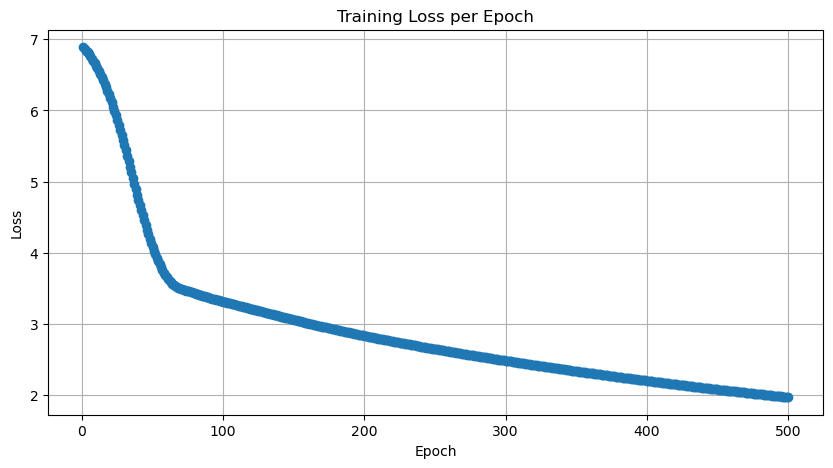

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np


# Encode the target variable
label_encoder = LabelEncoder()
targets = label_encoder.fit_transform(data['antigen.epitope'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    np.stack(data['kmer_vectors'].values), targets, test_size=0.2, random_state=42
)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

import matplotlib.pyplot as plt
# Initialize the loss values list
loss_values = []

# Training the model
num_epochs = 500
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    loss_values.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), loss_values, marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()
